# Projeto Final

Professor: Elias Jacob

Aluno: Alexandre Estrela de L. Nobrega

Conjunto de Dados: ToLD-Br

---

#### Resumo do Conjunto de Dados

ToLD-Br é o maior conjunto de dados para tweets tóxicos em português brasileiro, desenvolvido a partir de 42 anotadores selecionados a partir de um grupo de 129 voluntários. Os anotadores foram selecionados visando criar um grupo plural em termos de demografia (etnia, orientação sexual, idade, gênero). Cada tweet foi rotulado por três anotadores em 6 categorias possíveis: LGBTQ+fobia, Xenofobia, Obsceno, Insulto, Misoginia e Racismo.

Dado os rótulos, foi possível definir um dataset com texto do tweet (string) seguido por uma classe binária “tóxica” com valores 0 ou 1. O valor de 0 representa um texto não tóxico, e 1 representa um comportamento tóxico.

---

[Baixar dados.](https://github.com/JAugusto97/ToLD-Br/blob/main/experiments/data/1annotator.zip)

[Fonte dos dados.](https://huggingface.co/datasets/told-br) 

#### Configurando Dados

In [1]:
import pandas as pd

# Importando Dados
df = pd.read_csv('datas/ptbr_train_1annotator.csv')
#df_test = pd.read_csv('datas/ptbr_test_1annotator.csv')
#df_validation = pd.read_csv('datas/ptbr_validation_1annotator.csv')

# Visualizando Dados
df.head()

,text,toxic
0,"rt @user olha quem chegouuuuu, nossos queridin...",0
1,veio umas teorias muito loucas na minha cabeça...,1
2,@user @user 😂😂😂😂mais nao tinha falado ontem qu...,0
3,rt @user quer ser filha da puta logo comigo qu...,1
4,vai besta 😂😂😂😂 casquei com a ultima foto,1


#### Função de Limpeza de Dados

In [2]:
# Funções para limpeza de dados

import unicodedata

def accented_characters(text):

    normalized_text = unicodedata.normalize('NFKD', text)

    ascii_text = normalized_text.encode('ASCII', 'ignore')

    return ascii_text.decode()

import re

def numbers_and_punctuation(text):

    text = re.sub(r'[^a-zA-Z ]', ' ', text)

    return text

def excessive_spaces(text):

    text = re.sub(r'\s+', ' ', text)

    return text

def n_words(text, n):

    text = ' '.join([word for word in text.split() if len(word) > n])

    return text

def all_clear(text, ac = 0, np = 0, es = 0, nw = 0, n = 1):

    if ac == 1:
        text = accented_characters(text)

    if np == 1:
        text = numbers_and_punctuation(text)

    if es == 1:
        text = excessive_spaces(text)

    if nw == 1:
        text = n_words(text, n)

    return text

In [3]:
# Aplicando limpeza de dados
df['text'] = df['text'].astype(str).apply(all_clear, ac=1, np=1, es=1, nw=1, n=1)

# Visualizando Dados
df.head()

,text,toxic
0,rt user olha quem chegouuuuu nossos queridinho...,0
1,veio umas teorias muito loucas na minha cabeca...,1
2,user user mais nao tinha falado ontem que nao ...,0
3,rt user quer ser filha da puta logo comigo que...,1
4,vai besta casquei com ultima foto,1


#### Análise de Palavras mais Citadas

É sempre bom ter uma noção das palavras que mais aparecem nas frases dos usuários, para assim receber possíveis direcionamentos na criação das funções de rotulagem.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import numpy as np

stopwords_nltk = stopwords.words('portuguese')

# Carregar as stopwords em português
vectorizer = TfidfVectorizer(stop_words=stopwords_nltk, max_features=2000, ngram_range=(1, 2), min_df=5, max_df=0.8, lowercase=True)

# Criar um vetor TF-IDF
vectorizer.fit(df.text) # Ajuste apenas com os dados de treinamento.

# Transformar os textos em vetores
X_train = vectorizer.transform(df.text)
y_train = df.toxic

def get_top_ngrams(X_train: np.ndarray, vectorizer: TfidfVectorizer, top_n: int = 30) -> np.ndarray:
    """
    Obter os n-grams mais frequentes dos dados textuais vetorizados.

    Args:
        X_treino (np.ndarray): Os dados textuais vetorizados.
        vectorizer (TfidfVectorizer): O vetor utilizado para transformar os dados textuais.
        top_n (int, optional): O número de top n-grams a retornar. Padrão é 30.

    Returns:
        np.ndarray: Um array dos n-grams mais frequentes.
    """
    # Somar todas as colunas para obter a frequência total de cada n-gram
    total_ngram_frequencies = np.sum(X_train, axis=0)

    # Ordenar os n-grams pela sua frequência total
    sorted_ngrams_indices = np.argsort(total_ngram_frequencies)[::-1]

    # Obter os índices dos top n n-grams mais frequentes
    top_ngrams_indices = sorted_ngrams_indices[:top_n]

    # Obter os nomes dos n-grams correspondentes aos top n índices
    ngram_names = np.array(vectorizer.get_feature_names_out())

    return ngram_names[top_ngrams_indices]

# Usar a função para obter os top 30 n-grams dos dados de treinamento
top_ngrams = get_top_ngrams(X_train, vectorizer, top_n=30)

print('Palavras mais citadas:\n')

for words in top_ngrams:
    for i, word in enumerate(words):
        print(word, end=', ')
        if i % 5 == 0 and i != 0:
            print()

        if i == 10:
            break

Palavras mais citadas:

gt gt, honesto, proximidade, voces nao, salles, ano passado, 
aqui nao, primeira impressao, voce vai, correr, pequena, 


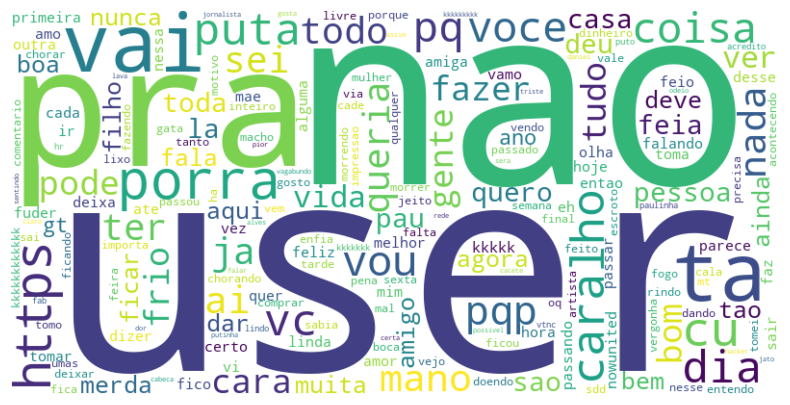

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Flatten the list of lists into a single list of words
all_words = [word for words in top_ngrams for word in words]

# Join all words into a single string
text = ' '.join(all_words)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Separando DataFrame entre Treino, Teste e Desenvolvimento

In [6]:
import math

from sklearn.model_selection import train_test_split

# Criando backup do DataFrame original:
df_label = df.copy()

z = 1.96 # Valor Z para nível de confiança de 95%
p = 0.5 # Proporção esperada de avaliações positivas. Assumimos 50%, que é o pior cenário.
e = 0.05 # Margem de erro

# Calculando tamanho da amostra e arredondando
tamanho_amostra = math.ceil((z**2 * p * (1-p)) / e**2)

print(f"\nTamanho da amostra: {tamanho_amostra}.\n")

# Embaralhando ordem do DataFrame
df_label = df_label.sample(frac=1.0, random_state=1)

# Criando novo DataFrame para treino com primeira metade do DataFrame embaralhado
df_train = df_label[tamanho_amostra * 2:]

# Criando DataFrame para treino final com primeira metade do DataFrame embaralhado
df_train_final = df_label[tamanho_amostra * 2:]

# Excluindo rótulos do DataFrame de Treino
df_train = df_train.drop('toxic', axis=1)

# Criando novo DataFrame para teste com segunda metade do DataFrame embaralhado
df_develop_test = df_label[:tamanho_amostra * 2]

# Dividindo aleatoriamente DataFrames entre teste e desenvolvimento
df_test, df_develop = train_test_split(df_develop_test, 
                                       test_size=0.5, 
                                       random_state=1, 
                                       stratify=df_develop_test.toxic)

print(f"Tamanho do conjunto de dados original: {len(df_label)}.")
print(f"Tamanho do conjunto de treinamento: {len(df_train)}.")
print(f"Tamanho do conjunto de teste: {len(df_test)}.")
print(f"Tamanho do conjunto de desenvolvimento: {len(df_develop)}.")


Tamanho da amostra: 385.

Tamanho do conjunto de dados original: 16800.
Tamanho do conjunto de treinamento: 16030.
Tamanho do conjunto de teste: 385.
Tamanho do conjunto de desenvolvimento: 385.


#### Labeling Functions (Funções de Rotulagem | LF) para Palavras

As funções de rotulagem de palavras para o presente dataset, servirão para definir com base nas palavras da frase do usuário, se seu comentário foi tóxico ou não.

- **( 1 ) Tóxico**: Quando alguma palavra ofensiva e/ou tóxica está presente na frase.

- **( 0 ) Não tóxico**: Quando alguma palavra de elogio e/ou gentil está presente na frase.

- **( -1 ) Abstenção**: Quando as palavras tóxicas ou não tóxicas não estiverem presentes na frase.

In [7]:
import re

from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier

# Definindo um dicionário com os padrões regex
regex_patterns = {
    "e_amor": r'amor',
    "o_boiola": r'boiola',
    "e_bom dia": r'bom dia',
    "e_boa tarde": r'boa tarde',
    "o_buceta": r'buceta',
    "o_bunda": r'bunda',
    "e_carai": r'carai',
    "o_caralho": r'caralho',
    "o_cu": r'cu',
    "e_feliz": r'feliz',
    "o_f[uo]de": r'f[uo]de',
    "e_incrivel": r'incrivel',
    "e_lind[oa]": r'lind[oa]',
    "e_maravilhos[oa]": r'maravilhos[oa]',
    "o_merd": r'merd',
    "e_mulherao": r'mulherao',
    "o_pal": r'pal',
    "o_pica": r'pica',
    "o_pinto": r'pinto',
    "o_piranha": r'piranha',
    "o_podre": r'podre',
    "o_porra": r'porra',
    "o_pqp": r'pqp',
    "o_put": r'put',
    "o_putinh": r'putinh',
    "o_ridicul": r'ridicul',
    "o_sapatao": r'sapatao',
    "o_tnc": r'tnc',
    "o_vaca": r'vaca',
    "o_vagabund": r'vagabund',
    "o_viado": r'viado',
    "e_vsf": r'vsf',
    "o_vtnc": r'vtnc'
}

# Função que define funções que definem as Labeling Funcions
def create_labeling_function(index, pattern, label_positive, label_negative):

    regex = re.compile(pattern, re.IGNORECASE)

    @labeling_function(name=f'lf_r_{index}')
    def lf(x):
        return label_positive if regex.search(x.text) else label_negative
    
    return lf

# Definindo Funções de Labeling Functions
lfs = []

for i, item in regex_patterns.items():

    if i[0] == 'o':
        lfs.append(create_labeling_function(i, item, 1, -1))

    else:
        lfs.append(create_labeling_function(i, item, 0, -1))

applier = PandasLFApplier(lfs=lfs)

Nota-se que a esmagadora maioria das das palavras definidas nas LF's não estão presentes no gráfico da nuvem de palavras. Porém é importante ter em mente que a escolha das palavras que irão compor elas não está unicamente associada a quantidade de vezes que elas aparecem nos textos, pois também é relevante escolher palavras com alto grau de certeza de que caso elas componham a frase, será obtido um rótulo correto.

##### Analisando Influência das Funções de Rotulagem

1. **j**: Índice da função de rotulagem

2. **Polarity**: Se a LF se refere a tóxidade e/ou não tóxidade.

3. **Coverage**: Proporção de vezes que uma função de rotulagem forneceu rotulos para instâncias (amostras de dados).

4. **Overlaps**: Proporção de vezes que uma função de rotulagem forneceu rótulos para instâncias que foram rotuladas por pelo menos outra função de rotulagem de mesma polaridade.

5. **Conflicts**: Proporção de vezes que uma função de rotulagem atribuiu rótulos de polaridade diferente dos rótulos atribuídos por outras funções de rotulagem para as mesmas instâncias.

In [8]:
from snorkel.labeling import LFAnalysis

# Aplica as funções de rotulagem (lfs) no conjunto de dados de treinamento (df_label_train_tain)
# L_train é uma matriz onde cada linha representa um exemplo e cada coluna representa a saída de uma função de rotulagem
L_train = applier.apply(df=df_train)

print(f'\nTotal Coverge: {LFAnalysis(L=L_train, lfs=lfs).label_coverage()}.')

# Cria uma instância de LFAnalysis para analisar o desempenho das funções de rotulagem
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

100%|██████████| 16030/16030 [00:04<00:00, 3826.20it/s]



Total Coverge: 0.536930754834685.


,j,Polarity,Coverage,Overlaps,Conflicts
lf_r_e_amor,0,[0],0.022021,0.012227,0.010792
lf_r_o_boiola,1,[1],0.001934,0.000374,0.000250
lf_r_e_bom dia,2,[0],0.002246,0.001310,0.001061
lf_r_e_boa tarde,3,[0],0.000873,0.000437,0.000250
lf_r_o_buceta,4,[1],0.003493,0.001622,0.000187
lf_r_o_bunda,5,[1],0.004616,0.003431,0.000686
lf_r_e_carai,6,[0],0.016594,0.003369,0.002870
lf_r_o_caralho,7,[1],0.079538,0.025639,0.007548
lf_r_o_cu,8,[1],0.117467,0.042296,0.009108
lf_r_e_feliz,9,[0],0.012976,0.005864,0.005053


A tabela mostra que as LF's conseguiram cobrir aproximadamente 54% de todo o dataset, com algumas palavras que estiveram presentes na nuvem de palavras (porra e cu) ganhando destaque por seu alto *Coverage*, e baixo *Conflict*.

##### Analisando o Acerto das Funções de Rotulagem

In [9]:
# Aplica as funções de rotulagem (lfs) no conjunto de dados de desenvolvimento (df_label_train_develop)
# L_dev é uma matriz onde cada linha representa um exemplo e cada coluna representa a saída de uma função de rotulagem
L_dev = applier.apply(df=df_develop)

# Cria uma instância de LFAnalysis para analisar o desempenho das funções de rotulagem, com acertos e erros
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=df_develop.toxic.values)

100%|██████████| 385/385 [00:00<00:00, 3457.98it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_r_e_amor,0,[0],0.031169,0.018182,0.018182,9,3,0.750000
lf_r_o_boiola,1,[1],0.002597,0.002597,0.000000,1,0,1.000000
lf_r_e_bom dia,2,[0],0.005195,0.002597,0.002597,2,0,1.000000
lf_r_e_boa tarde,3,[0],0.005195,0.005195,0.002597,1,1,0.500000
lf_r_o_buceta,4,[1],0.010390,0.002597,0.000000,4,0,1.000000
lf_r_o_bunda,5,[1],0.007792,0.005195,0.000000,3,0,1.000000
lf_r_e_carai,6,[0],0.010390,0.002597,0.002597,3,1,0.750000
lf_r_o_caralho,7,[1],0.103896,0.031169,0.005195,27,13,0.675000
lf_r_o_cu,8,[1],0.083117,0.025974,0.005195,21,11,0.656250
lf_r_e_feliz,9,[0],0.018182,0.007792,0.005195,5,2,0.714286


Como pode ser visto na tabela, todas as funções de rotulagem obtiveram um grau de acertabilidade, ao comparar com os rótulos originais, igual ou maior que 50% (com a esmagadora maioria sendo maior).

##### Analisando Conflito entre Funções de Rotulagem

In [10]:
def compute_conflict_matrices(L_train, lfs):

    # Função para criar e processar a matriz de conflitos normalizada
    def process_conflict_matrix(L, lfs, normalize=False, column_name='conflict'):
        lf_analysis = LFAnalysis(L=L, lfs=lfs)
        conflict_matrix = lf_analysis.lf_conflicts(normalize_by_overlaps=normalize)
        conflict_matrix = pd.DataFrame([conflict_matrix], columns=[lf.name for lf in lfs]).T
        conflict_matrix.columns = [column_name]
        conflict_matrix = conflict_matrix.sort_values(by=column_name, ascending=False)
        return conflict_matrix

    # Calcular a matriz de conflitos normalizada
    normalized_conflict_matrix = process_conflict_matrix(L_train, lfs, normalize=True, column_name='normalized_conflict')

    # Calcular a matriz de conflitos não normalizada
    conflict_matrix = process_conflict_matrix(L_train, lfs, normalize=False, column_name='conflict')

    # Concatenar as duas matrizes de conflitos
    final_cm = pd.concat([conflict_matrix, normalized_conflict_matrix], axis=1)

    return final_cm

# Calcular a matriz de conflitos final
compute_conflict_matrices(L_train, lfs)

,conflict,normalized_conflict
lf_r_e_lind[oa],0.010917,0.866337
lf_r_e_amor,0.010792,0.882653
lf_r_o_cu,0.009108,0.215339
lf_r_o_porra,0.007611,0.299754
lf_r_o_caralho,0.007548,0.294404
lf_r_o_pqp,0.005864,0.365759
lf_r_e_feliz,0.005053,0.861702
lf_r_o_put,0.004991,0.173536
lf_r_e_vsf,0.003119,0.793651
lf_r_e_carai,0.002870,0.851852


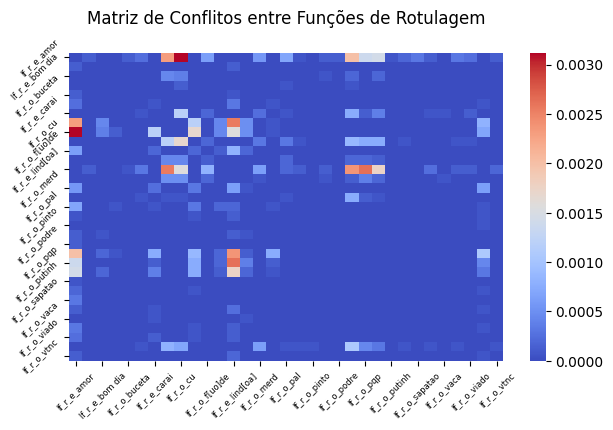

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def conflict_matrix(lfs, L):

    """
    Esta função calcula a matriz de conflitos para um conjunto de funções de rotulagem e um conjunto de dados rotulados.

    Args:
    - lfs: Uma lista de funções de rotulagem.
    - L: Um array numpy de forma (num_examples, num_lfs) contendo os rótulos atribuídos por cada função de rotulagem a cada exemplo.

    Retorna:
    - Um DataFrame do pandas contendo a matriz de conflitos.
    """

    # Inicializa uma matriz de zeros com forma (num_lfs, num_lfs)
    conflict_matrix = np.zeros((len(lfs), len(lfs)))

    # Calcula o conflito entre cada par de funções de rotulagem
    for i in range(len(lfs)):
        for j in range(len(lfs)):
            # Calcula o conflito entre as funções de rotulagem i e j
            conflict_matrix[i, j] = ((L[:, i] != L[:, j]) & (L[:, i] != -1) & (L[:, j] != -1)).mean()

    # Converte a matriz de conflitos para um DataFrame do pandas com os nomes das funções de rotulagem como rótulos das linhas e colunas
    conflict_matrix = pd.DataFrame(conflict_matrix, columns=[lf.name for lf in lfs], index=[lf.name for lf in lfs])
    return conflict_matrix

def matrix_graph(lfs, L_train):

    # Plotar a matriz de conflitos usando seaborn
    plt.figure(figsize=(7, 4))
    sns.heatmap(conflict_matrix(lfs, L_train), annot=False, cmap="coolwarm", cbar=True, annot_kws={"fontsize": 6})
    plt.title("Matriz de Conflitos entre Funções de Rotulagem\n")
    plt.xticks(rotation=45, fontsize=6)
    plt.yticks(rotation=45, fontsize=6)
    plt.show()

matrix_graph(lfs, L_train)

O gráfico da matriz de conflito demonstra que de forma geral é bem baixo o índice de conflitos, com apenas alguns pontos apresentando uma maior diferença do padrão.

#### Labeling Functions para Palavras com uso de Transformer

O uso de um transformer como LF, será a aplicação de um modelo pré-treinado (a partir de um dataset com características semelhantes) para a rotulação das instâncias. O autor do transformer utilizado no presente carderno o define como um classificador de sequência de modelo multilíngue Distil-Bert treinado com base no conjunto de dados JIGSAW Toxic Comment Classification Challenge.

---

O autor do transformer explica que o modelo foi treinado em um subconjunto aleatório do conjunto de dados told-br (1/3 do tamanho original). Ele deixa claro que o principal objetivo é fornecer um pequeno modelo que possa ser usado para classificar tweets em português brasileiro de forma binária ('tóxico' ou 'não tóxico').

O conjunto de dados que o transformer utilizou curiosamente foi o mesmo que está sendo usado no presente estudo. Será interessante ver como ele desempenhará apenas compondo parte das funções de rotulagem.

---

[Fonte do modelo do Transformer.](https://huggingface.co/inctdd/told_br_binary_sm)

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Define o caminho do modelo (um caminho local ou um identificador de modelo de huggingface.co/models)
model_path = "inctdd/told_br_binary_sm"

# Carrega o tokenizador e o modelo
tokenizer_hf = AutoTokenizer.from_pretrained(model_path)
model_hf = AutoModelForSequenceClassification.from_pretrained(model_path)

# Cria um classificador de sentimento que une o tokenizador e o modelo como um pipeline
toxic_classifier = pipeline("text-classification", model=model_hf, tokenizer=tokenizer_hf, device=1 if torch.cuda.is_available() else -1, verbose=False)

# Imprime o dispositivo em que o modelo está. Cuda significa GPU, caso contrário, CPU. GPU é mais rápido.
print(f'- Modelo em que o dispositivo está: {model_hf.device}.\n')

for row in df_train.sample(10, random_state=1).itertuples():
    print(f'Text: {row.text}')
    print(f'Label: {toxic_classifier(row.text)[0]['label']}')
    print(f'Score: {toxic_classifier(row.text)[0]['score']}\n')

- Modelo em que o dispositivo está: cpu.

Text: estou juntando dinheiro no cofre focoooo vou encher essa porra toda
Label: 0
Score: 0.630939781665802

Text: user Depois de encher rabo com dinheiro da lei Rouanet se aproveitar do dinheiro dos pagadores de imposto tem cara de pau de vir publico defender militantes disfarcados de jornalistas cujo unico objetivo soltar Jumento de nove dedos
Label: 1
Score: 0.9713601469993591

Text: user de cair cu da bunda
Label: 1
Score: 0.9717990159988403

Text: user bah entao tu imagina com vou ficar quase tao linda quanto tu
Label: 0
Score: 0.9809370636940002

Text: montando meu primeiro curriculo para estagio la no hospital so consigo pensar beleza nome ja foi agora que que eu escrevo
Label: 0
Score: 0.9876489043235779

Text: boa tarde so pra quem ta com fome de cu
Label: 1
Score: 0.9587632417678833

Text: to ligada no pqp
Label: 1
Score: 0.5966371893882751

Text: hoje eu acordei com uma vontade de morrer me olhei no espelho nao aguentei nao suporto n

Criando Labeling Function para Transformer

In [13]:
from snorkel.preprocess import preprocessor

# Define um pré-processador usando a função de decorador do Snorkel
@preprocessor(memoize=True)
def hf_toxic(x):

    """
    Esta função é um pré-processador que usa um classificador de toxidade pré-treinado para adicionar
    uma etiqueta de previsão e um score aos dados de entrada.

    Args:
    - x: Um objeto contendo os dados de entrada, que deve ter um atributo 'text' contendo o texto a ser classificado.

    Retorna:
    - O mesmo objeto de entrada 'x', mas com atributos adicionais 'pred_label' e 'score' adicionados com base nas previsões do modelo.
    """

    # Define argumentos para o tokenizador, garantindo que o texto seja preenchido e truncado para um comprimento máximo de 512 tokens
    tokenizer_kwargs = {'padding': True, 'truncation': True, 'max_length': 512}

    # Obtém as pontuações de sentimento do classificador de sentimento pré-treinado
    # O [0] no final é usado para obter o primeiro (e único) resultado do classificador, pois a saída é uma lista de previsões
    scores = toxic_classifier(x.text, **tokenizer_kwargs)[0]

    # Adiciona a etiqueta prevista ('label') e a pontuação ('score') aos atributos do objeto 'x'
    x.pred_label = scores.get('label')
    x.score = scores.get('score')

    # Retorna o objeto 'x' modificado
    return x

@labeling_function(pre=[hf_toxic])
def lf_hf_toxic(x):

    """
    Esta função de rotulagem atribui um rótulo baseado no sentimento previsto por um classificador de sentimento pré-treinado.

    Args:
    - x: Um objeto de entrada que deve ter atributos 'pred_label' e 'score' adicionados pelo pré-processador 'hf_toxic'.

    Retorna:
    - ( 1) se a pontuação do sentimento for maior ou igual a 0.85 e o rótulo previsto por 'toxic'.
    - ( 0) se a pontuação do sentimento for maior ou igual a 0.85 e o rótulo previsto for 'not_toxic'.
    - (-1) caso contrário.
    """

    # Verifica se a pontuação do sentimento é maior ou igual a 0.85
    if x.score >= 0.85:

        # Se o rótulo previsto for 'Positive', retorna YES
        if x.pred_label == '1':
            return 1
        
        # Se o rótulo previsto for 'Negative', retorna NO
        elif x.pred_label == '0':
            return 0
    
    # Retorna ABSTAIN se a pontuação for menor que 0.85 ou o rótulo não for 'toxic' nem 'not_toxic'
    return -1

lfs.append(lf_hf_toxic)

Aplicando as Funções de Rotulagem antigas com a nova do Transformer

In [14]:
applier = PandasLFApplier(lfs=lfs)

L_train = applier.apply(df=df_train)

L_dev = applier.apply(df=df_develop)

print(f'\nTotal Coverge: {LFAnalysis(L=L_dev, lfs=lfs).label_coverage()}.')

LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=df_develop.toxic.values)

100%|██████████| 385/385 [00:42<00:00,  9.01it/s]


Total Coverge: 0.8649350649350649.


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_r_e_amor,0,[0],0.031169,0.031169,0.018182,9,3,0.750000
lf_r_o_boiola,1,[1],0.002597,0.002597,0.000000,1,0,1.000000
lf_r_e_bom dia,2,[0],0.005195,0.005195,0.002597,2,0,1.000000
lf_r_e_boa tarde,3,[0],0.005195,0.005195,0.002597,1,1,0.500000
lf_r_o_buceta,4,[1],0.010390,0.010390,0.000000,4,0,1.000000
lf_r_o_bunda,5,[1],0.007792,0.007792,0.000000,3,0,1.000000
lf_r_e_carai,6,[0],0.010390,0.002597,0.002597,3,1,0.750000
lf_r_o_caralho,7,[1],0.103896,0.044156,0.010390,27,13,0.675000
lf_r_o_cu,8,[1],0.083117,0.072727,0.028571,21,11,0.656250
lf_r_e_feliz,9,[0],0.018182,0.018182,0.005195,5,2,0.714286


O transformer aumentou a cobertura de rotulação das instâncias de aproximadamente 54% para 86%, um aumento significativo de aproximadamente 32%. Porém, é importante perceber que o transformer atingiu um alto índice de conflito.

Analisando a nova Matriz de Conflito

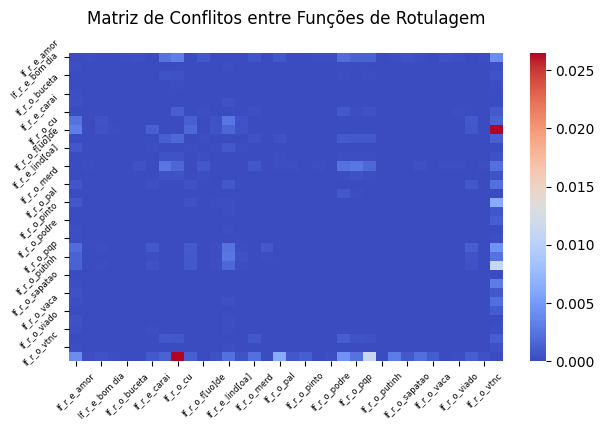

In [15]:
matrix_graph(lfs, L_train)

O índice de acertabilidade do transformer como visto na tabela foi extremamente alto, contudo, mesmo assim apresentou erros, e liderou o conflito com as outras funções de rotulagem, principalmente com a palavra *cu* que é a mais citada das palavras escolhidas para compor as LF's.

#### Labeling Functions de Modelo Treinado a partir de dados rotulados por as LF's das Palavras e do Transformer

- A lógica que se segue é treinar um modelo de aprendizado de máquinas a partir das LF's criadas anteriormente, e criar uma LF com ele.

Definindo Função para treinamento de diferentes modelos

In [16]:
from typing import List, Tuple
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, classification_report, matthews_corrcoef, confusion_matrix
import time

def train_and_evaluate_classification_models(X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, List]:

    """
    Train multiple classification models and evaluate their performance.

    Args:
        X (pd.DataFrame): The training data.
        y (pd.Series): The training labels.

    Returns:
        Tuple[pd.DataFrame, List]: A DataFrame with the performance metrics of each model and a list of classification reports.
    """

    random_state = 314
    
    # Define the models to be trained
    models = []
    models.append(('Calibrated-LSVC', CalibratedClassifierCV(LinearSVC(random_state=314, class_weight='balanced', dual='auto'))))
    models.append(('LR', LogisticRegression(random_state=314, n_jobs=-1, class_weight='balanced')))
    models.append(('RF', RandomForestClassifier(random_state=314, n_jobs=-1, class_weight='balanced')))
    models.append(('XGB', XGBClassifier(random_state=314, n_jobs=-1, class_weight='balanced', verbosity=0)))
    models.append(('MLP', MLPClassifier(random_state=314)))
    models.append(('NB', MultinomialNB()))
    models.append(('LSVC', LinearSVC(random_state=314, class_weight='balanced')))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('DT', DecisionTreeClassifier(random_state=314, class_weight='balanced')))
    models.append(('ExtraTrees', ExtraTreesClassifier(random_state=314, n_jobs=-1, class_weight='balanced')))
    
    
    performance_results = []
    classification_reports = []
    
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    for model_name, model in models:
        start_time = time.time()

        try:
            predicted_labels = cross_val_predict(estimator=model, X=X, y=y, cv=cross_validation,
                                     method="predict", n_jobs=2)
        except Exception as e:
            print(f'Error {model_name} - {e}')
            continue 

        f1 = f1_score(y, predicted_labels, average='micro')
        balanced_accuracy = balanced_accuracy_score(y, predicted_labels)
        accuracy = accuracy_score(y, predicted_labels)
        classification_report_str = classification_report(y, predicted_labels)
        matthews_corr_coeff = matthews_corrcoef(y, predicted_labels)
        confusion_mat = confusion_matrix(y, predicted_labels)
        classification_reports.append([model_name, classification_report_str, confusion_mat])

        elapsed_time = time.time() - start_time
        performance_results.append([model_name, f1, balanced_accuracy, accuracy, matthews_corr_coeff, elapsed_time, confusion_mat, classification_report_str])

        '''
        print(f'Model: {model_name} - F1: {f1:.4f} - Balanced Accuracy: {balanced_accuracy:.4f} - Accuracy: {accuracy:.4f} - Matthews Correlation Coefficient: {matthews_corr_coeff:.4f} - Elapsed time: {elapsed_time:.2f}s')
        print(classification_report_str)
        print(confusion_mat)
        print('*' * 20, '\n')
        '''

    results_df = pd.DataFrame(performance_results, columns=['Model', 'F1', 'Balanced Accuracy', 'Accuracy', 'Matthews Correlation Coefficient', 'Elapsed Time', 'Confusion Matrix', 'Classification Report'])
    results_df['Confusion Matrix'] = results_df['Confusion Matrix'].apply(lambda x: str(x))

    return results_df, classification_reports

Desempenho de diferentes modelos treinados a partir de Funções de Rotulagens que misturam a identificação de palavras com o Transformer

In [17]:
tfidf_vec_ssl = TfidfVectorizer(ngram_range=(1,2), strip_accents='unicode', lowercase=True, max_features=2000, min_df=3)

X_dev = tfidf_vec_ssl.fit_transform(df_develop.text)
X_dev = X_dev.toarray()

y_dev = df_develop.toxic.values

print('Shape:', X_dev.shape, '\n')

df_results, creports = train_and_evaluate_classification_models(X_dev, y_dev) 

df_results.sort_values(by='Matthews Correlation Coefficient', ascending=False)

Shape: (385, 374) 



,Model,F1,Balanced Accuracy,Accuracy,Matthews Correlation Coefficient,Elapsed Time,Confusion Matrix,Classification Report
6,LSVC,0.644156,0.636821,0.644156,0.273009,0.169900,[[152 70]\n [ 67 96]],precision recall f1-score ...
8,DT,0.631169,0.621483,0.631169,0.243378,0.252122,[[152 70]\n [ 72 91]],precision recall f1-score ...
3,XGB,0.633766,0.615583,0.633766,0.237437,1.407682,[[163 59]\n [ 82 81]],precision recall f1-score ...
2,RF,0.638961,0.606229,0.638961,0.236414,1.497457,[[182 40]\n [ 99 64]],precision recall f1-score ...
1,LR,0.623377,0.613096,0.623377,0.226776,0.240224,[[151 71]\n [ 74 89]],precision recall f1-score ...
5,NB,0.633766,0.600094,0.633766,0.224138,0.150079,[[182 40]\n [101 62]],precision recall f1-score ...
9,ExtraTrees,0.618182,0.594733,0.618182,0.198714,1.247638,[[166 56]\n [ 91 72]],precision recall f1-score ...
4,MLP,0.584416,0.567084,0.584416,0.136814,5.690514,[[151 71]\n [ 89 74]],precision recall f1-score ...
0,Calibrated-LSVC,0.584416,0.536920,0.584416,0.094075,1.764345,[[188 34]\n [126 37]],precision recall f1-score ...
7,KNN,0.584416,0.529583,0.584416,0.084848,0.179999,[[197 25]\n [135 28]],precision recall f1-score ...


Desempenho de diferentes modelos treinados a partir de apenas o Transformer

In [18]:
# Usando um modelo de transformador para gerar embeddings e depois usar um classificador em cima disso

from sentence_transformers import SentenceTransformer
from IPython.display import clear_output

PATH_LM = 'inctdd/told_br_binary_sm'
model = SentenceTransformer(PATH_LM)

X_dev_transformer = model.encode(df_develop.text.values, batch_size=64, show_progress_bar=True, convert_to_tensor=False)

df_results, creports = train_and_evaluate_classification_models(X_dev_transformer, y_dev) 

clear_output(wait=True)

print(model.encode('teste').shape)

print(X_dev_transformer.shape, '\n')

df_results.sort_values(by='Matthews Correlation Coefficient', ascending=False)

(768,)
(385, 768) 



,Model,F1,Balanced Accuracy,Accuracy,Matthews Correlation Coefficient,Elapsed Time,Confusion Matrix,Classification Report
8,ExtraTrees,0.828571,0.823633,0.828571,0.648361,1.180001,[[190 32]\n [ 34 129]],precision recall f1-score ...
2,RF,0.815584,0.809111,0.815584,0.620974,1.955261,[[189 33]\n [ 38 125]],precision recall f1-score ...
3,XGB,0.807792,0.801539,0.807792,0.605189,10.979467,[[187 35]\n [ 39 124]],precision recall f1-score ...
6,KNN,0.800000,0.796413,0.800000,0.591455,0.175097,[[182 40]\n [ 37 126]],precision recall f1-score ...
4,MLP,0.750649,0.745468,0.750649,0.490164,5.801871,[[173 49]\n [ 47 116]],precision recall f1-score ...
1,LR,0.748052,0.744031,0.748052,0.486251,0.609632,[[171 51]\n [ 46 117]],precision recall f1-score ...
7,DT,0.740260,0.731567,0.740260,0.465651,1.544923,[[175 47]\n [ 53 110]],precision recall f1-score ...
0,Calibrated-LSVC,0.709091,0.693127,0.709091,0.396131,9.157617,[[177 45]\n [ 67 96]],precision recall f1-score ...
5,LSVC,0.688312,0.680001,0.688312,0.360610,3.773913,[[163 59]\n [ 61 102]],precision recall f1-score ...


Os modelos treinados apenas pelo transformer obtiveram melhor desempenho do que os treinados com as funções de rotulagem que uniram a identificação de palavras mais o transformer. Contudo, por mais que tenha tido um desempenho inferior, para o bem do trabalho continuaremos usando as funções de rotulagem, para gerar um resultado com a partir de formas mais variadas de rotulação.

Criando Função de Rotulagem para melhor modelo obtido a partir do treinamento dos diversos modelos para o DataFrame de desenvolvimento

In [19]:
model_ssl = CalibratedClassifierCV(LinearSVC(random_state=314, class_weight='balanced', dual='auto'), cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=314))
model_ssl = model_ssl.fit(X_dev, y_dev)

# Define uma função de pré-processamento que adiciona um rótulo previsto e uma pontuação a um exemplo dado usando um classificador empilhado
@preprocessor(memoize=True)
def train_model_predict(x):
    """
    Esta função é um pré-processador que usa um modelo LinearSVC pré-treinado para adicionar
    uma etiqueta de previsão e um score aos dados de entrada.

    Args:
    - x: Um objeto contendo os dados de entrada, que deve ter um atributo 'text' contendo o texto a ser classificado.

    Retorna:
    - O mesmo objeto de entrada 'x', mas com atributos adicionais 'pred_label' e 'score' adicionados com base nas previsões do modelo.
    """
    # Transformar o texto usando o vetorizador TF-IDF
    X_input = tfidf_vec_ssl.transform([x.text])
    
    # Obter as previsões do modelo
    pred_label = model_ssl.predict(X_input)
    pred_score = model_ssl.predict_proba(X_input).max(axis=1)
    
    # Adicionar a etiqueta prevista ('pred_label') e a pontuação ('score') aos atributos do objeto 'x'
    x.pred_label = int(pred_label[0])
    x.score = float(pred_score[0])
    
    return x

@labeling_function(pre=[train_model_predict])
def lf_train_model(x):
    """
    Esta função de rotulagem atribui um rótulo baseado nas previsões do modelo LinearSVC.

    Args:
    - x: Um objeto de entrada que deve ter atributos 'pred_label' e 'score' adicionados pelo pré-processador 'custom_model_predict'.

    Retorna:
    - (1) se a pontuação for maior ou igual a 0.65 e o rótulo previsto for '1'.
    - (0) se a pontuação for maior ou igual a 0.65 e o rótulo previsto for '0'.
    - (-1) caso contrário.
    """

    if x.score >= 0.7:
        if x.pred_label == 1:
            return 1
        elif x.pred_label == 0:
            return 0
    else:
        return -1

# Remova qualquer função de rotulagem duplicada
lfs.append(lf_train_model)

In [20]:
applier = PandasLFApplier(lfs=lfs)

L_train = applier.apply(df=df_train)

LFAnalysis(L_train, lfs).lf_summary()

L_dev = applier.apply(df=df_develop)

print(f'\nTotal Coverge: {LFAnalysis(L=L_dev, lfs=lfs).label_coverage()}.')

LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=df_develop.toxic.values)

100%|██████████| 385/385 [00:04<00:00, 94.22it/s] 


Total Coverge: 0.8805194805194805.


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_r_e_amor,0,[0],0.031169,0.031169,0.018182,9,3,0.750000
lf_r_o_boiola,1,[1],0.002597,0.002597,0.000000,1,0,1.000000
lf_r_e_bom dia,2,[0],0.005195,0.005195,0.002597,2,0,1.000000
lf_r_e_boa tarde,3,[0],0.005195,0.005195,0.002597,1,1,0.500000
lf_r_o_buceta,4,[1],0.010390,0.010390,0.000000,4,0,1.000000
lf_r_o_bunda,5,[1],0.007792,0.007792,0.000000,3,0,1.000000
lf_r_e_carai,6,[0],0.010390,0.002597,0.002597,3,1,0.750000
lf_r_o_caralho,7,[1],0.103896,0.044156,0.010390,27,13,0.675000
lf_r_o_cu,8,[1],0.083117,0.072727,0.028571,21,11,0.656250
lf_r_e_feliz,9,[0],0.018182,0.018182,0.005195,5,2,0.714286


O modelo treinado aumentou a cobertura de rotulagem de aproximadamente 86% para 88%. Não é um aumentou substancial, porém se mostrou útil.

    Recapitulando conceitos a partir de modelo de rotulagem final (Palavras + Transformer + Modelo de Aprendizado de Máquinas) obtido:

1. Cobertura das Funções de Rotulagem:

    - As funções de rotulagem podem cobrir diferentes partes do conjunto de dados, ou seja, algumas funções podem rotular mais exemplos que outras. Isso é o que significa "cobertura".

2. Sobreposição e Conflito:

    - As funções de rotulagem podem se sobrepor, o que significa que mais de uma função pode rotular o mesmo exemplo.
Elas também podem entrar em conflito, o que significa que diferentes funções podem atribuir rótulos diferentes ao mesmo exemplo.

3. Precisões:

    - Cada função de rotulagem pode ter uma precisão diferente, ou seja, algumas podem ser mais precisas na atribuição de rótulos corretos do que outras.

4. Histograma:

    - Para entender melhor a cobertura total das funções de rotulagem, podemos visualizar um histograma que mostra quantos rótulos foram atribuídos pelos LFs aos pontos de dados no conjunto de treinamento.
    - Esse histograma ajuda a dar uma ideia de quantos exemplos foram rotulados por nenhuma, uma ou várias funções de rotulagem, o que é essencial para avaliar a qualidade e a cobertura do processo de rotulagem automática.

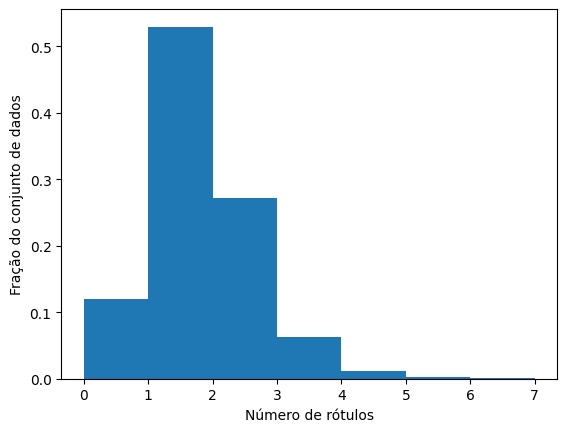

In [21]:
%matplotlib inline

def plot_label_distribution(label_matrix: np.ndarray) -> None:
    """
    Plota a distribuição do número de rótulos por exemplo no conjunto de dados.

    Args:
        label_matrix (np.ndarray): Um array 2D numpy onde cada linha representa um exemplo e cada coluna representa um rótulo.
                                   O valor é -1 se o rótulo não for atribuído ao exemplo, e um valor diferente caso contrário.

    Returns:
        None
    """
    # Calcular o número de rótulos para cada exemplo
    num_labels_per_example = (label_matrix != -1).sum(axis=1)
    
    # Plotar um histograma do número de rótulos por exemplo
    # plt.hist(num_labels_per_example, density=True, bins=range(label_matrix.shape[1])) # Para o caso de querer deixar o eixo x com o número total de rótulos
    plt.hist(num_labels_per_example, density=True, bins=range(8)) # Delimitar manualmente o número de rótulos no eixo x

    # Definir o rótulo do eixo x
    plt.xlabel("Número de rótulos")
    
    # Definir o rótulo do eixo y
    plt.ylabel("Fração do conjunto de dados")
    
    # Mostrar o gráfico
    plt.show()

# Plotar a frequência de rótulos no conjunto de treinamento
plot_label_distribution(L_train)

O gráfico mostra que a maioria das instâncias foram rotuladas por entre uma e duas funções de rotulagem. Isso se deve ao Transformer aliado ao modelo de AM que possuíram altos Overlaps, cobrindo assim as funções de rotulagens das palavras.

#### Comparando treinamento modelo de AM para DataFrame com Rótulos Reais, e Rótulos de Funções de Rotulagem

    OBS: RETIRANDO ABSTENÇÕES DO DF COM RÓTULOS ORIGINAIS E GERADOS

Atribuindo Rótulos obtidos a partir de Funções das Rotulagem no DataFrame para Treino Final

In [22]:
from snorkel.labeling.model import LabelModel

# Criando cópia do DF de treino
df_train_final_total = df_train_final.copy()

# Treinar um modelo de rótulo para combinar os rótulos das LFs
label_model = LabelModel(cardinality=2, verbose=False)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=314)

# Obter os rótulos finais
df_train_final_total['toxic_LF'] = label_model.predict(L=L_train)

# Excluindo rótulos inconclusivos (-1)
df_train_final_total = df_train_final_total[df_train_final_total['toxic_LF'] != -1]

# Analisando acurácia dos rótulos das LFs que foram rotuladas com sucesso (sem o valor de -1)
print(f'\nF1      : {f1_score(df_train_final_total['toxic'], df_train_final_total['toxic_LF'], average='micro'):.4f}')
print(f'Accuracy: {accuracy_score(df_train_final_total['toxic'], df_train_final_total['toxic_LF']):.4f}\n')

df_train_final_total.head()

100%|██████████| 500/500 [00:01<00:00, 361.28epoch/s]



F1      : 0.7826
Accuracy: 0.7826



,text,toxic,toxic_LF
2422,rt user ai so porque tirou ele cai https co kr...,0,0
15371,pior duvida,0,0
7312,user giovana vai se fuder mano fica pffff,1,1
1524,harry caralho nao que tu bom mesmo https co nt...,1,1
13716,rt user eu ia falar contigo mas tu tava com ca...,0,0


Como pode ser visto, os rótulos gerados a partir das LFs previstos com sucesso (diferentes de -1) obtiveram uma acurácia de **78.26%** comparando diretamente com rotulos reais.

In [23]:
# Ajustar o vetor TF-IDF no conjunto de treinamento
tfidf_vec_ssl.fit(df_train_final_total.text)

# Transformar o conjunto de treinamento e de teste com o vetor TF-IDF ajustado
X_train = tfidf_vec_ssl.transform(df_train_final_total.text)
X_train = X_train.toarray()

X_test = tfidf_vec_ssl.transform(df_test.text)
X_test = X_test.toarray()

# Converter os rótulos para arrays
y_train = df_train_final_total.toxic.values
y_train_LF = df_train_final_total.toxic_LF.values
y_test = df_test.toxic.values

print('Shape Train:', X_train.shape)
print('Shape Test:', X_test.shape)

Shape Train: (14105, 2000)
Shape Test: (385, 2000)


Apenas para fins de verificação de qual modelo treinado (o com rotulagens reais e o com rotulagens geradas) do DataFrame de treino melhor irá predizer dados novos, que serão os ainda intocados do DataFrame de teste. Para isso será utilizado o modelo de treinamento já usado anteriormente (LSVC). Ele foi escolhido visando diminuir o custo computacional do teste, dado as limitações da máquina utilizada.

In [24]:
# Treinando modelo com rótulos reais
model_ssl_train = CalibratedClassifierCV(LinearSVC(random_state=314, class_weight='balanced', dual='auto'), cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=314))
model_ssl_train = model_ssl_train.fit(X_train, y_train)

# Treinando modelo com rótulos gerados
model_ssl_train_LF = CalibratedClassifierCV(LinearSVC(random_state=314, class_weight='balanced', dual='auto'), cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=314))
model_ssl_train_LF = model_ssl_train_LF.fit(X_train, y_train_LF)

In [25]:
f1_orig = f1_score(y_test, model_ssl_train.predict(X_test), average='micro')
f1_gen = f1_score(y_test, model_ssl_train_LF.predict(X_test), average='micro')

mcc_orig = matthews_corrcoef(y_test, model_ssl_train.predict(X_test))
mcc_gen = matthews_corrcoef(y_test, model_ssl_train_LF.predict(X_test))

acc_orig = accuracy_score(y_test, model_ssl_train.predict(X_test))
acc_gen = accuracy_score(y_test, model_ssl_train_LF.predict(X_test))

bac_orig = balanced_accuracy_score(y_test, model_ssl_train.predict(X_test))
bac_gen = balanced_accuracy_score(y_test, model_ssl_train_LF.predict(X_test))

pd.DataFrame(data = {
    'Métrica': ['F1S', 'MCC', 'ACC', 'BAC'],
    'Rótulos Originais': [f1_orig, mcc_orig, acc_orig, bac_orig],
    'Rótulos Gerados': [f1_gen, mcc_gen, acc_gen, bac_gen]
})

,Métrica,Rótulos Originais,Rótulos Gerados
0,F1S,0.750649,0.766234
1,MCC,0.483009,0.522897
2,ACC,0.750649,0.766234
3,BAC,0.732424,0.762242


Por incrível que pareça, o dataframe com **rótulos gerados** desempenhou melhor que o com **rótulos originais** na predição do DataFrame de teste. É um resultado curioso, e um pouco assustador. Porém, é importante notar que as linhas com textos com os resultados inconclusivos (-1) para os **rótulos gerados**, foram retirados tanto deles como dos **rótulos originais**. Se faz necessário verificar se caso eles estivessem no treinamento do dataframe dos **rótulos originais**, ele acabaria gerando predições melhores que a dos **rótulos gerados** por causa da maior cobertura de casos.

#### Comparando treinamento modelo de AM para DataFrame com Rótulos Reais, e Rótulos de Funções de Rotulagem


    OBS: RETIRANDO ABSTENÇÕES APENAS DO DF COM GERADOS

In [26]:
from snorkel.labeling.model import LabelModel

# Criando cópia do DF de treino
df_train_final_com_abstencao = df_train_final.copy()

# Criando DF de predição
df_train_final_sem_abstencao = pd.DataFrame()
df_train_final_sem_abstencao['text'] = df_train_final_com_abstencao['text']

# Treinar um modelo de rótulo para combinar os rótulos das LFs
label_model = LabelModel(cardinality=2, verbose=False)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=314)

# Obter os rótulos finais
df_train_final_sem_abstencao['toxic'] = label_model.predict(L=L_train)

# Excluindo rótulos inconclusivos (-1)
df_train_final_sem_abstencao = df_train_final_sem_abstencao[df_train_final_sem_abstencao['toxic'] != -1]

# Observando diferença de quantidade de dados dos DFs com 
# rótulos originais e gerados
print('')
print(df_train_final_com_abstencao.info(), '\n')
print(df_train_final_sem_abstencao.info())

100%|██████████| 500/500 [00:00<00:00, 598.64epoch/s]



<class 'pandas.core.frame.DataFrame'>
Index: 16030 entries, 2422 to 235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16030 non-null  object
 1   toxic   16030 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 375.7+ KB
None 

<class 'pandas.core.frame.DataFrame'>
Index: 14105 entries, 2422 to 12172
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14105 non-null  object
 1   toxic   14105 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 275.5+ KB
None


In [27]:
# Ajustar o vetor TF-IDF no conjunto de treinamento
tfidf_vec_ssl.fit(df_train_final_com_abstencao.text)
tfidf_vec_ssl.fit(df_train_final_sem_abstencao.text)

# Transformar o conjunto de treinamento e de teste com o vetor TF-IDF ajustado
X_train_com_abstencao = tfidf_vec_ssl.transform(df_train_final_com_abstencao.text)
X_train_com_abstencao = X_train_com_abstencao.toarray()

X_train_sem_abstencao = tfidf_vec_ssl.transform(df_train_final_sem_abstencao.text)
X_train_sem_abstencao = X_train_sem_abstencao.toarray()

X_test = tfidf_vec_ssl.transform(df_test.text)
X_test = X_test.toarray()

# Converter os rótulos para arrays
y_train_com_abstencao = df_train_final_com_abstencao.toxic.values
y_train_sem_abstencao = df_train_final_sem_abstencao.toxic.values
y_test = df_test.toxic.values

print('Shape de Treino com Abstenções:', X_train_com_abstencao.shape)
print('Shape de Treino sem Abstenções:', X_train_sem_abstencao.shape)
print('Shape de Teste:', X_test.shape)

Shape de Treino com Abstenções: (16030, 2000)
Shape de Treino sem Abstenções: (14105, 2000)
Shape de Teste: (385, 2000)


In [28]:
# Treinando modelo com rótulos reais
model_ssl_train_com_abstencao = CalibratedClassifierCV(LinearSVC(random_state=314, class_weight='balanced', dual='auto'), cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=314))
model_ssl_train_com_abstencao = model_ssl_train_com_abstencao.fit(X_train_com_abstencao, y_train_com_abstencao)

# Treinando modelo com rótulos gerados
model_ssl_train_sem_abstencao = CalibratedClassifierCV(LinearSVC(random_state=314, class_weight='balanced', dual='auto'), cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=314))
model_ssl_train_sem_abstencao = model_ssl_train_sem_abstencao.fit(X_train_sem_abstencao, y_train_sem_abstencao)

In [29]:
f1_orig = f1_score(y_test, model_ssl_train_com_abstencao.predict(X_test), average='micro')
f1_gen = f1_score(y_test, model_ssl_train_sem_abstencao.predict(X_test), average='micro')

mcc_orig = matthews_corrcoef(y_test, model_ssl_train_com_abstencao.predict(X_test))
mcc_gen = matthews_corrcoef(y_test, model_ssl_train_sem_abstencao.predict(X_test))

acc_orig = accuracy_score(y_test, model_ssl_train_com_abstencao.predict(X_test))
acc_gen = accuracy_score(y_test, model_ssl_train_sem_abstencao.predict(X_test))

bac_orig = balanced_accuracy_score(y_test, model_ssl_train_com_abstencao.predict(X_test))
bac_gen = balanced_accuracy_score(y_test, model_ssl_train_sem_abstencao.predict(X_test))

pd.DataFrame(data = {
    'Métrica': ['F1S', 'MCC', 'ACC', 'BAC'],
    'Rótulos Originais': [f1_orig, mcc_orig, acc_orig, bac_orig],
    'Rótulos Gerados': [f1_gen, mcc_gen, acc_gen, bac_gen]
    })

,Métrica,Rótulos Originais,Rótulos Gerados
0,F1S,0.745455,0.766234
1,MCC,0.471954,0.522897
2,ACC,0.745455,0.766234
3,BAC,0.727104,0.762242


Novamente os rótulos originais obtiveram uma acurácia menor que a dos rótulos gerados. É curioso, mas essas são algumas possíveis explicações analisadas. 

- **DataFrame de Teste**: O DataFrame de teste foi um recorte do dataset não usado durante todo o aprendizado de máquinas, porém, pode ser que esse recorte em particular seja melhor representado pelo modelo treinado com o DF com rótulos gerados, do que pelo modelo treinado com o DF com rótulos originais.

- **Exclusão de Dados Ambiguos**: Ao extrair os comentários que as LFs não conseguiram rotular, retira-se com isso comentários que podem ser contraditórios para a máquina. Isso pode ser constatado ao notar que o DF com rótulos originais que tiveram as abstenções das LFs excluídas geraram um modelo melhor do que  o DF que não excluiu. Aliado a outros fatores, isso pode ter agravado o motivo que levou a uma menor acurácia.

- **Influência do Transformer**: Por mais que o transformer tenha apenas integrado parte das LF's que realizaram a rotulagem, ele se trata de um modelo para o mesmo dataset do trabalho, logo, a influência dele junto de outros fatores pode ter sido preponderante para que o DataFrame com rótulos gerados tenha gerado predições melhores que o DataFrame com rótulos originais.

- **Modelo de Aprendizado de Máquinas**: A primeira é que como o modelo treinado foi o mesmo usado para os dois, sem ajustes de acordo com cada um dos DF's, talvez ele por acaso seja mais ajustado ao DF dos rótulos gerados, contudo, caso fosse ajustado um modelo para cada um dos dois DF's, visando elevar de forma particular para cada suas respectivas acurácias, os rótulos originais obtivessem resultados melhores que os rótulos gerados.

- **Particularidades do Dataset**: O dataset usado visando extrair comentários tóxicos dos usuários do twitter por si só é rotulado de forma subjetiva. Isto porque comentários que usam palavras de baixo calão não necessariamente são tóxicos, e a interpretação pode variar bastante dependendo de quem o analisa. Logo, pode ser que os rótulos atribuídos pelas LB's demonstrem menos subjetividade, e por mais que os dados usados para testar a acurácia possua rótulos originais não usados no treinamento, de alguma forma essa diminuição da subjetividade tenha ajudado no treinamento do modelo de AM.

- **Tamanho do Dataset**: O tamanho do dataset também pode ter sido um fator preponderante. Isto por que talvez a quantidade de dados usados no treinamento tenham limitado mais a capacidade de predição do DF com rótulos originais, do que a do DF com rótulos gerados.

De qualquer forma, para este caso, com este Dataset, os rótulos gerados para o Dataset se mostrou mais eficaz que os rótulos originais no treinamento de modelos de aprendizado de máquinas.